# iLykei Lecture Series
# Machine Learning
# Main Deep Learning Models: CNN


## Yuri Balasanov, Leonid Nazarov, &copy; iLykei 2019

## Preparing image

First, read image with library [imageio](https://pypi.python.org/pypi/imageio) (install it via `conda install imageio` in Terminal).

In [1]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.utils import plot_model
from keras.initializers import Constant
from keras.optimizers import RMSprop
import numpy as np
import pandas as pd
import json

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
import numpy as np
import imageio

Using TensorFlow backend.


In [2]:
x = imageio.imread('cat.jpeg')
x.shape  

(300, 400, 3)

Note that in the shape of the image the dimensions of the image come first $(300 \times 400)$ and the number of channels is the last dimension $(3)$.

Plot the image:

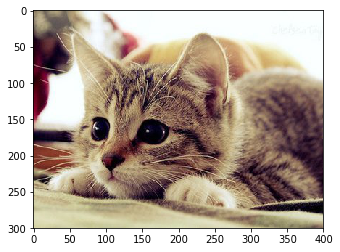

In [3]:
plt.imshow(x)
plt.savefig('cat.png')

## Convolution layer

Assemble a model containing only input and convolutional layer.

Convolutional layer is [defined by](https://keras.io/layers/convolutional/):

`keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', activation=None, use_bias=True, kernel_initializer='glorot_uniform', ...)`

where:

- filters: Integer, the dimensionality of the output space (i.e. the number of filters in the convolution) 
- kernel_size: An integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions  
- strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the width and height. Can be a single integer to specify the same value for all spatial dimensions 
- padding: One of "valid" or "same" (case-insensitive). In case of "valid" pixels on the edge of image that do not make complete kernel are dropped; in case of "same" they are padded by zeros to make a complete kernel.
- activation: Activation function to use (see activations). If not specified, no activation is applied (ie. "linear" activation: a(x) = x)
- use_bias: Boolean, whether the layer uses a bias vector
- kernel_initializer: Initializer for the kernel weights matrix (see initializers).

Create convolution layer with 4 filters, kernel size $(21 \times 21)$ and strides $(1 \times 1)$.

In [4]:
inputs = Input((None, None, 3))
conv = Conv2D(filters=4, kernel_size=(21, 21), strides=(1,1), 
              padding='same', use_bias=False)(inputs)
conv_model = Model(inputs=inputs, outputs=conv)

Plot the network.

If the following code results in an error message because pydot and graphviz are not installed [this post](https://www.codesofinterest.com/2017/02/visualizing-model-structures-in-keras.html) may help.

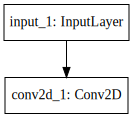

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(conv_model).create(prog='dot', format='svg'))

See shapes of input and output in the summary

In [6]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 4)     5292      
Total params: 5,292
Trainable params: 5,292
Non-trainable params: 0
_________________________________________________________________


There are $5292=21 \times 21 \times 3 \times 4$ parameters in the constructed convolution layer. By default they are randomly initialized. 

Apply the convolution layer with such randomly initialized filters to the image:

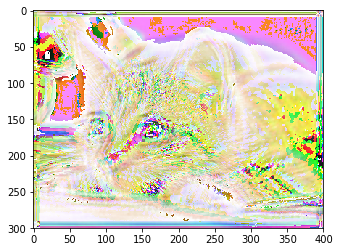

In [7]:
batch = np.expand_dims(x, 0)  # model.predict expects not one image, but a batch of images
y0 = conv_model.predict(batch)[0].astype('uint8')

plt.imshow(y0)

It may look creepy sometimes! <br>

Now, instead of random initialization of the layer fix convolution weights.

Reduce the size of the network to 3 filters: one will be applied to each channel.

First, apply horizontal filter and pass it to the layer without training.

In [8]:
inputs = Input((None, None, 3))
conv = Conv2D(filters=3, kernel_size=(21, 21), strides=(1,1), 
              padding='same', use_bias=False)(inputs)
conv_model = Model(inputs=inputs, outputs=conv)
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     3969      
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [9]:
horizontal_filter = np.zeros(shape=(21,21,3,3))
for i in range(3):
    horizontal_filter[10,:,i,i] = 1.0/21.0
# fixing convolution weights
conv_model.layers[1].set_weights([horizontal_filter])

Apply convolution with horizontal filter to each channel of the image:

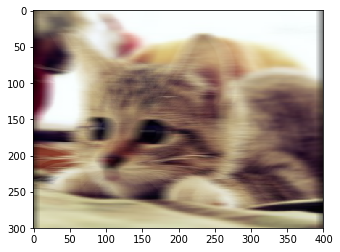

In [10]:
y1 = conv_model.predict(batch)[0].astype('uint8')
plt.imshow(y1)

Note that horizontal lines (such as cat's whiskers) get enhanced, while everything else gets blurred.

Create a vertical filter and apply it to the same image.

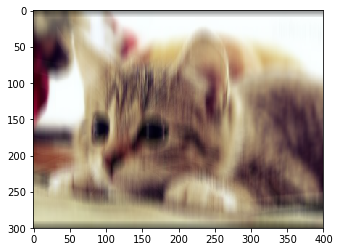

In [11]:
vertical_filter = np.zeros(shape=(21,21,3,3))
for i in range(3):
    vertical_filter[:,10,i,i] = 1.0/21.0
conv_model.layers[1].set_weights([vertical_filter])
y2 = conv_model.predict(batch)[0].astype('uint8')
plt.imshow(y2)
plt.savefig('cat2.png')

Note that this time vertical lines (such as cat's claws or vertical fur stripes) get enhanced, while everything else gets blurred.

## MaxPooling Layer

Creating [max pooling](https://faroit.github.io/keras-docs/1.1.2/layers/pooling/) layer   is done by:

`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='default')`


- pool_size: tuple of 2 integers, factors by which to downscale (vertical, horizontal). Default value (2, 2) will halve the image in each dimension.
- strides: tuple of 2 integers, or None. Strides values. If None, it will default to pool_size.
- border_mode: 'valid' or 'same'.
- dim_ordering: 'th' or 'tf'. In 'th' mode, the channels dimension (the depth) is at index 1, in 'tf' mode is it at index 3. It defaults to the `image_dim_ordering` value found in Keras config file at ~/.keras/keras.json. If you never set it, then it will be "tf".

Assemble a model with only an input and max pooling layer.

In [12]:
inputs = Input((None, None, 3))
maxpool = MaxPooling2D(pool_size=(2, 2))(inputs)
maxpool_model = Model(inputs=inputs, outputs=maxpool)
maxpool_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 3)     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


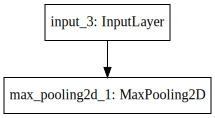

In [13]:
SVG(model_to_dot(maxpool_model).create(prog='dot', format='svg'))

Apply MaxPool to the cat image:

(300, 400, 3)
(150, 200, 3)


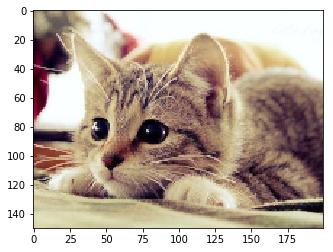

In [14]:
y3 = maxpool_model.predict(batch)[0].astype('uint8')
print(x.shape)
print(y3.shape)
plt.imshow(y3)

Note that MaxPooling transformation downscales original image in each dimension according to `pool_size`.

# Fashion-MNIST Data exploration

This example is based on `fashion-mnist` dataset of Zalando's clothing articles images in Keras. It has same structure as `mnist`: 60,000 of 28x28 images in train and 10,000 in test samples for classification. Thus it is recommended as a drop-in replacement for the original `mnist` dataset for benchmarking machine learning algorithms. 

There are [several reasons](https://github.com/zalandoresearch/fashion-mnist) for replacement of `mnist` as a benchmark data. Probably the most important of them: `mnist` has become too simple in comparison with modern pattern recognition problems: it can relatively easily allow accuracy of 97%. Even more: it is [possible](https://gist.github.com/dgrtwo/aaef94ecc6a60cd50322c0054cc04478) to successfully do pairwise distinguishing of `mnist` images by looking at just one(!) pixel.

Load the data.

In [15]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# next few lines needed instead to run on RCC GPU
#x_train = np.load('x_train.npy')
#x_test = np.load('x_test.npy')
#y_train = np.load('y_train.npy')
#y_test = np.load('y_test.npy')

In [16]:
print("X_train shape: ",x_train.shape, "\nY_train shape: ",y_train.shape)
print("X_test shape: ",x_test.shape, "\nY_test shape: ",y_test.shape)

X_train shape:  (60000, 28, 28) 
Y_train shape:  (60000,)
X_test shape:  (10000, 28, 28) 
Y_test shape:  (10000,)


Plot an arbitrary image.

Label:  0
Shape:  (28, 28)


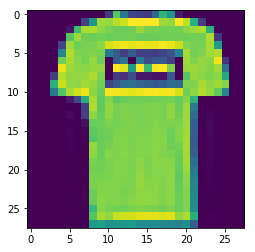

In [17]:
print('Label: ',y_train[1])
print('Shape: ',x_train[1].shape)
plt.imshow(x_train[1])
plt.show()

Create a dictionary of labels in order to show them on the image plots.

In [18]:
LabelData = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'AnkleBoot'
}

Text(0.5,1,'Object: Pullover')

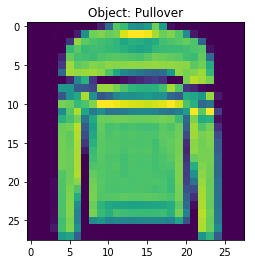

In [19]:
plt.imshow(x_train[5])
plt.title("Object: " + str(LabelData[y_train[5]]))

Find distribution of labels in the train sample.

In [20]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 6000,
 1: 6000,
 2: 6000,
 3: 6000,
 4: 6000,
 5: 6000,
 6: 6000,
 7: 6000,
 8: 6000,
 9: 6000}

Plot a little more images from the set.

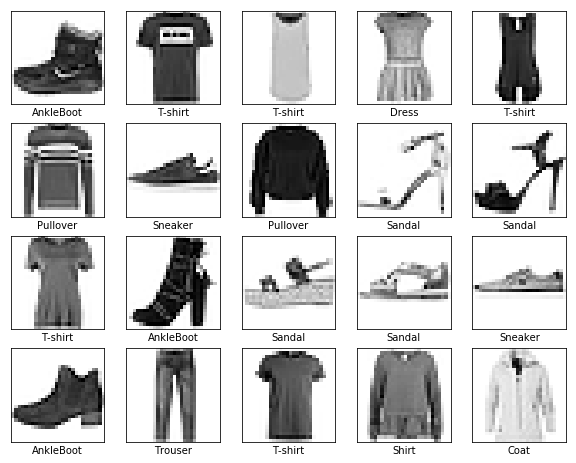

In [21]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i],cmap="Greys")
    plt.xlabel(LabelData[y_train[i]])
    

# Data preparation

Prepare the data for analysis.

In [22]:
batch_size = 128
num_classes = 10
epochs = 40

In [23]:
img_rows, img_cols = 28, 28

Check in which format the images are: number of channels first or last.

In [24]:
K.image_data_format()

'channels_last'

Create reshaped train and test images to be `(#samples, #rows, #columns, #channels)`.

In [25]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Scale the images.

In [26]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Convert class vectors to binary class matrices.

In [27]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Model

A hint to still simple, but pretty powerful model below comes from [here](https://github.com/khanguyen1207/My-Machine-Learning-Corner/blob/master/Zalando%20MNIST/fashion.ipynb).

Create the following function putting the model together.

In [28]:
def makeModel(dropout_rate_1=0.0, dropout_rate_2=0.0, dropout_rate_3=0.0, 
             cnn_units_1=32, cnn_units_2=64, dense_units= 128):
    #np.random.seed(1)
    model = Sequential()
    model.add(Conv2D(cnn_units_1, kernel_size=(5, 5),
                 padding='same',
                 bias_initializer=Constant(0.02),
                 kernel_initializer='random_uniform',
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(cnn_units_1, kernel_size=(5, 5),
                 padding='same',
                 bias_initializer=Constant(0.02),
                 kernel_initializer='random_uniform',
                 activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(dropout_rate_1))
    if cnn_units_2 > 0:
        model.add(Conv2D(cnn_units_2, kernel_size=(3, 3),
                 padding='same',
                 bias_initializer=Constant(0.02),
                 kernel_initializer='random_uniform',
                 activation='relu'))
        model.add(Conv2D(cnn_units_2, kernel_size=(3, 3),
                 padding='same',
                 bias_initializer=Constant(0.02),
                 kernel_initializer='random_uniform',
                 activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same'))
        model.add(Dropout(dropout_rate_2))
    model.add(Flatten())
    if dense_units > 0:
        model.add(Dense(dense_units, activation='relu',
                bias_initializer=Constant(0.02),
                kernel_initializer='random_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate_3))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer=RMSprop(lr=0.001,rho=0.9,epsilon=1e-08,decay=0.0)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])
    return model

In [29]:
model = makeModel(dropout_rate_1=0.25, dropout_rate_2=0.25, dropout_rate_3=0.5, 
             cnn_units_1=32, cnn_units_2=64, dense_units= 512)

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
__________

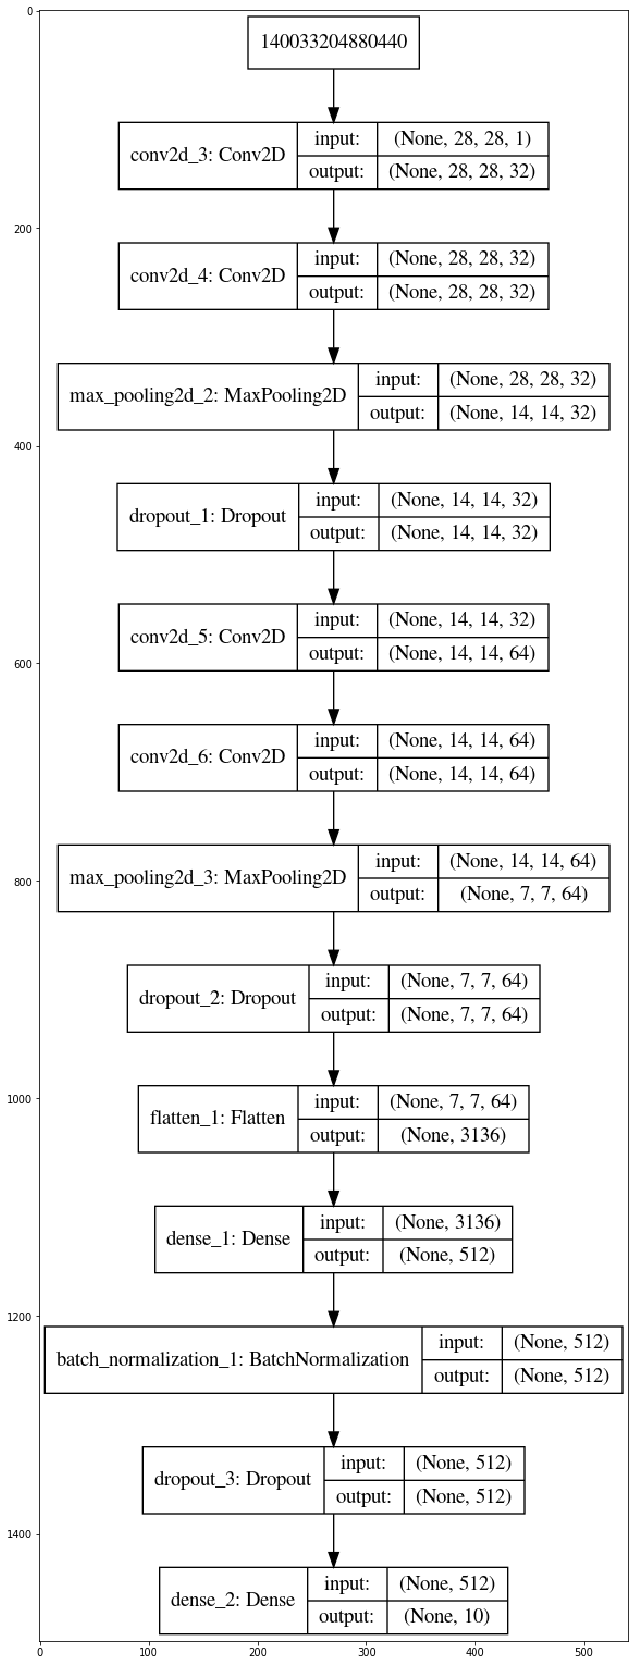

In [31]:
mpl.rcParams['figure.figsize'] = (25,30)

plot_model(model, to_file='fashion_mnist.png', show_shapes=True)
plt.imshow(imageio.imread('fashion_mnist.png'))

Fit the model or load previously fitted and saved model from file.

In [32]:
# Run if there is no saved model
#his = model.fit(x_train, y_train,
#          batch_size=batch_size,
#          epochs=epochs,
#          verbose=1,
#          validation_data=(x_test, y_test))

In [33]:
# Run if need to save fitted model
#model.save('cnn_fashion_mnist.h5')


In [34]:
# Run if there is saved model 
loaded_model=load_model('cnn_fashion_mnist.h5')

Save the history of fitting to file or load it from file if it has been saved earlier.

In [35]:
# Run if there is no saved history

#with open('fit_history.json','w') as f:
#    json.dump(his.history,f)

In [36]:
# Run if there is saved history
with open('fit_history.json') as json_file:
    loaded_his=json.load(json_file)

Plot train and test loss. Also plot train and test accuracy of the model

Final train and test loss:  [0.12112632326285044] [0.2613535293996334]


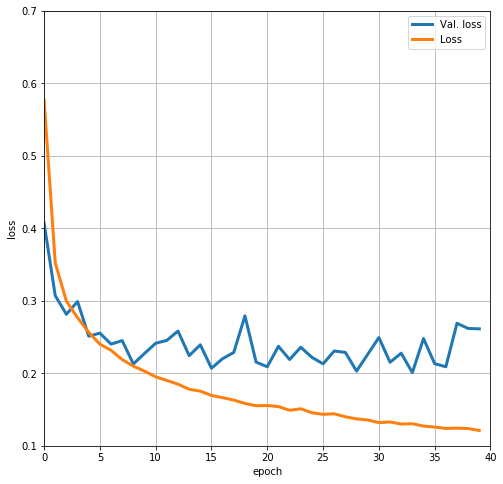

In [37]:
mpl.rcParams['figure.figsize'] = (8,8)

valid_loss = loaded_his["val_loss"]
loss= loaded_his["loss"]
print('Final train and test loss: ',loss[-1:],valid_loss[-1:])

plt.plot(valid_loss, linewidth=3, label="Val. loss")
plt.plot(loss, linewidth=3, label="Loss")

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xlim(0, 40)
plt.ylim(0.1, 0.7)
plt.show()

Final train and test accuracy:  [0.9569333333333333] [0.936]


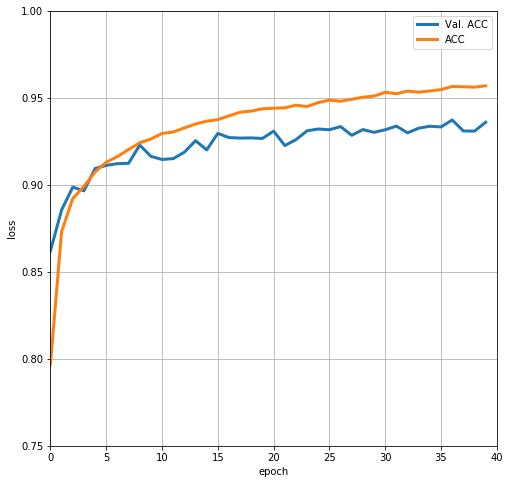

In [38]:
valid_acc = loaded_his["val_acc"]
acc= loaded_his["acc"]
print('Final train and test accuracy: ',acc[-1:],valid_acc[-1:])


plt.plot(valid_acc, linewidth=3, label="Val. ACC")
plt.plot(acc, linewidth=3, label="ACC")

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xlim(0, 40)
plt.ylim(0.75, 1)
plt.show()